In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator
import tomllib
import tomlkit as tml
import json
import xarray as xr
from csvb.ingest import apply_rule, sel_factory, ApplyOp, SelectOp, AOP, SOP, Rule, to_transactions, strip_currency
import plotly.express as px
import plotly.graph_objects as go
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True

In [2]:
def accounts(trans):
    return set(trans["From"]).union(set(trans["To"]))

def read_and_apply(df, rulepth, debug=False):
    with open(rulepth) as f:
        for rule in tml.load(f)["rules"]:
            if debug:
                print(rule)
            apply_rule(Rule(**rule), df)
    return df 

In [3]:
home = pathlib.Path.home()
cfgpth = home / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
cfg

{'title': 'csvb config',
 'paths': {'path': 'als/csvbdata/',
  'bank': 'als/csvbdata/bank',
  'products': 'als/csvbdata/products/',
  'rules': 'als/csvbdata/rules'}}

In [4]:
try:
    del apl
except NameError:
    pass
dfs = []
for fn in (home / pathlib.Path(cfg["paths"]["bank"])).glob("Apple Card Transactions*.csv"):
    dfs.append(pd.read_csv(fn, header=0, parse_dates=["Transaction Date", "Clearing Date"]))
apl = pd.concat(dfs)
apl = apl.rename(columns={"Amount (USD)": "Amount"})
apl["Amount"] = -1 * apl["Amount"]
apl["From"] = ""

apl = read_and_apply(apl, home / cfg["paths"]["rules"] / "aplrules.toml")
apl = apl.sort_values(["Transaction Date"])
#apl[apl["From"] == ""]
apl

,Transaction Date,Clearing Date,Description,Merchant,Category,Type,Amount,Purchased By,From
16,2021-12-31,2022-01-02,"FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...",Fandango,Entertainment,Purchase,-11.04,Keith Davis,Expenses:Entertainment
15,2021-12-31,2022-01-03,APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...,Apple Services,Other,Purchase,-14.99,Keith Davis,Expenses:Subscriptions
14,2022-01-01,2022-01-03,APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...,Apple Services,Other,Purchase,-5.99,Keith Davis,Expenses:Subscriptions
13,2022-01-01,2022-01-03,CKO*PATREON* MEMBERSHI600 TOWNSEND 833-9728766...,Cko*Patreon* Membershi,Other,Purchase,-7.00,Keith Davis,Expenses:Entertainment
12,2022-01-01,2022-01-03,APPLE.COM/BILL ONE APPLE PARK 1111111111 95014...,Apple Services,Other,Purchase,-30.14,Keith Davis,Expenses:Subscriptions
...,...,...,...,...,...,...,...,...,...
1,2024-02-29,2024-02-29,ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...,Ach Deposit Internet Transfer From Account End...,Payment,Payment,2161.31,Keith Davis,Transfer
50,2024-02-29,2024-02-29,MONTHLY INSTALLMENTS (1 OF 12),Monthly Installments (1 Of 12),Installment,Installment,-23.25,Keith Davis,Liabilities:Apple:Installments
51,2024-02-29,2024-02-29,MONTHLY INSTALLMENTS (22 OF 24),Monthly Installments (22 Of 24),Installment,Installment,-54.12,Keith Davis,Liabilities:Apple:Installments
49,2024-02-29,2024-02-29,MONTHLY INSTALLMENTS (1 OF 12),Monthly Installments (1 Of 12),Installment,Installment,-114.08,Keith Davis,Liabilities:Apple:Installments


In [5]:
try:
    del apl_inst
except NameError:
    pass

apl_inst = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Apple_Installments_Transactions.csv",
                    header=0, parse_dates=["Date"])

apl_inst["From"] = "Expenses:Electronics"
apl_inst

,Date,Description,Amount,From
0,2022-05-20,iPhone - Apple Store MISHAWAKA IN TRANSACTION ...,-1299.0,Expenses:Electronics
1,2022-05-20,iPhone AppleCare - Apple Store MISHAWAKA IN TR...,-199.0,Expenses:Electronics
2,2024-02-09,Mac Pro M3 - Apple Online Store Cupertino CA T...,-1369.0,Expenses:Electronics
3,2024-02-09,Mac Pro M3 AppleCare - Apple Online Store Cupe...,-279.0,Expenses:Electronics


In [6]:
try:
    del fst
except NameError:
    pass

fst = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_1st.csv",
                    header=3, parse_dates=["Date"])

fst_old = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Sep22-2023_1st_Source.csv",
                    header=3, parse_dates=["Date"])

fst_older = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan22-Sep22_1st_Source.csv",
                    header=3, parse_dates=["Date"])

fst = pd.concat([fst, fst_old, fst_older])

fst["Amount"] = np.nansum([fst["Amount Credit"],fst["Amount Debit"]], axis=0)
fst["From"] = ""

fst = read_and_apply(fst, home / cfg["paths"]["rules"] / "fstrules.toml")
fst[fst["From"] == ""]

,Transaction Number,Date,Description,Memo,Amount Debit,Amount Credit,Balance,Check Number,Fees,Amount,From


In [7]:
try:
    del ally
except NameError:
    pass

ally = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_Ally.csv",
                    header=0, parse_dates=["Date"])

ally["From"] = ""
ally = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))

ally = read_and_apply(ally, home / cfg["paths"]["rules"] / "allyrules.toml")
#ally

In [8]:
try:
    del ndfcu
except NameError:
    pass

ndfcu = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan2022-March-2024_NDFCU_CC.csv",
                    header=0, names=["Date", "Note", "Description", "Amount", "Balance"],
                    parse_dates=["Date"])

ndfcu["From"] = ""
ndfcu["Amount"] = ndfcu["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns:
ndfcu = read_and_apply(ndfcu, home / cfg["paths"]["rules"] / "ndfcurules.toml")
print(len(ndfcu))
ndfcu[ndfcu["From"] == ""]

1009

,Date,Note,Description,Amount,Balance,From


In [9]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu,
              "Liabilities:Apple:Installments": apl_inst}


trans = to_transactions(bank_tables)
trans.sort_values("Date")

,Date,Description,Amount,From,To
0,2021-12-31,PHILLIPS 66 - 0082 FIR . MISHAWAKA . IN 0000,-26.93,Expenses:Auto:Fuel,Liabilities:NDFCU:Credit Card
1,2021-12-31,MARTIN S SUPERMARKE . SOUTHBEND . IN 0000,-86.95,Expenses:Groceries,Liabilities:NDFCU:Credit Card
2,2021-12-31,APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...,-14.99,Expenses:Subscriptions,Liabilities:Apple:Credit Card
3,2021-12-31,"FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...",-11.04,Expenses:Entertainment,Liabilities:Apple:Credit Card
4,2022-01-01,CVS/PHARMACY #08642 . SOUTH BEND . IN 0000,-24.70,Expenses:Medical:Body,Liabilities:NDFCU:Credit Card
...,...,...,...,...,...
2211,2024-02-29,MONTHLY INSTALLMENTS (1 OF 12),-23.25,Liabilities:Apple:Installments,Liabilities:Apple:Credit Card
2210,2024-02-29,ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...,2161.31,Transfer,Liabilities:Apple:Credit Card
2209,2024-02-29,APPLE CASH PAYMENT,87.47,Income:Apple Cash,Liabilities:Apple:Credit Card
2212,2024-02-29,MONTHLY INSTALLMENTS (22 OF 24),-54.12,Liabilities:Apple:Installments,Liabilities:Apple:Credit Card


In [10]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])

#bal_decl["From"] = ""
#bal["Amount"] = bal["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))
#bal_decl = bal_decl.sort_values("Date")
#bal_decl
#jan_bal = bal_decl.loc[(bal_decl["Date"] >= pd.Timestamp(2023, 12, 31)) &
#                       (bal_decl["Date"] <= pd.Timestamp(2024, 1, 1))
#trans = pd.concat([trans, bal_decl])
bal_decl

,Date,Account,Statement Balance
0,2021-12-31,Liabilities:Apple:Credit Card,-2522.77
1,2021-12-31,Liabilities:Apple:Installments,-738.94
2,2021-12-31,Assets:1st Source:Checking,5067.54
3,2022-12-31,Liabilities:NDFCU:Credit Card,-76.69
4,2023-11-30,Liabilities:NDFCU:Credit Card,-2085.08
5,2023-10-31,Liabilities:NDFCU:Credit Card,-2492.89
6,2023-09-30,Liabilities:NDFCU:Credit Card,-1581.47
7,2023-08-31,Liabilities:NDFCU:Credit Card,-69.79
8,2023-07-31,Liabilities:NDFCU:Credit Card,-3172.26
9,2023-06-30,Liabilities:NDFCU:Credit Card,-1409.14


In [11]:
def create_ledgers(trans):
    """ Create a ledger for each account of all from / to transactions and create balance / time column.
    'Transaction Pair' is a terrible name, but it reminds that this is 1 half of a known transation for use
    as a ledger of an account and running balance calculation.
    All values appended from the "From" side of a transaction are reversed here, because a positive value
    "From" this account subtracts from it's balance.
    
    """
    # TODO: Add an option of a start of / end of period dates. Automatically calculate balance at
    # beginning of period.
    # TODO: Add processing of balance assertions to allow checks and reconciliation.
    
    fl = trans.groupby("From")
    tl = trans.groupby("To")
    ledgers = {}
    for acct in accounts(trans):
        # From accounts, note the negative applied to Amount.
        try:
            df = pd.DataFrame(trans.loc[fl.groups[acct], ["Date", "Description", "To"]]).rename(columns={"To": "Transaction Pair"})
            df["Incoming Amount"] = -1 * trans.loc[fl.groups[acct], "Amount"]
            ledgers[acct] = df
        # If account is not in From group, skip.
        except KeyError:
            pass

        # To accounts.

        try:
            df = pd.DataFrame(trans.loc[tl.groups[acct], ["Date", "Description", "From"]]).rename(columns={"From": "Transaction Pair"})
            df["Incoming Amount"] = trans.loc[tl.groups[acct], "Amount"]
            try:
                ledgers[acct] = pd.concat([ledgers[acct], df])
            # If account was not also in From accounts list, don't concat.
            except KeyError:
                ledgers[acct] = df
        # If account is not in list To accounts, skip.
        except KeyError:
            pass
            
        # Sort and apply cumulative sum.
        ledgers[acct] = ledgers[acct].sort_values("Date")
        ledgers[acct]["Balance"] = ledgers[acct]["Incoming Amount"].cumsum()

    return ledgers

def trans_to_ledger(trans, acct, bal_decl = None, clean=False, leq=True):
    """ Craete a single ledger. This is a step to using ledgers as a view on the transactions rather than
    a precalcualted object.
    
    """   
    fl = trans.groupby("From")
    tl = trans.groupby("To")
    #ledgers = {}
    #for acct in accounts(trans):
    # From accounts, note the negative applied to Amount.
    try:
        df = pd.DataFrame(trans.loc[fl.groups[acct], ["Date", "Description", "To"]]).rename(columns={"To": "Transaction Pair"})
        df["Incoming Amount"] = -1 * trans.loc[fl.groups[acct], "Amount"]
        ledger = df
        # If account is not in From group, skip.
    except KeyError:
        pass

    # To accounts.

    try:
        df = pd.DataFrame(trans.loc[tl.groups[acct], ["Date", "Description", "From"]]).rename(columns={"From": "Transaction Pair"})
        df["Incoming Amount"] = trans.loc[tl.groups[acct], "Amount"]
        try:
            ledger = pd.concat([ledger, df])
        # If account was not also in From accounts list, don't concat.
        except (NameError, UnboundLocalError):
            ledger = df
    # If account is not in list To accounts, skip.
    except KeyError:
        pass
    if clean:
        ledger = clean_ledger(ledger)        
    # Sort and apply cumulative sum.
    
    if bal_decl is not None:
        ledger = append_init_row(ledger, acct, bal_decl, leq=leq)
    ledger = ledger.sort_values("Date")
    ledger["Balance"] = ledger["Incoming Amount"].cumsum()

    return ledger

def clean_ledger(ledger):
    """Remove transactions occurring before the last transaction with all accounts assigned.
    Intended to catch incomplete data and return a useful ledger set on a per account basis.
    """
    #clean = {}
    #for acct in ledgers:
    try:
        clean = ledger.loc[[ledger["From"] == ""]:,:]
    except KeyError:
        clean = ledger
        
    return clean

def init_balance(bal_decl, acct, first_date, leq=False):
    #first_date = min(ledger["Date"])
    if leq:
        acct_balances = bal_decl.loc[(bal_decl["Account"] == acct) & (bal_decl["Date"] <= first_date)]
    else:
        acct_balances = bal_decl.loc[(bal_decl["Account"] == acct) & (bal_decl["Date"] < first_date)]
    
    # Catch indexerror if no balance found.
    try:
        return acct_balances.sort_values("Date").iloc[-1]
    except IndexError:
        return None

def append_init_row(ledger, acct, bal_decl, leq=False):
    #print(acct)
    #print(ledger)
    # Find proper initial balance.
    init = init_balance(bal_decl, acct, min(ledger["Date"]), leq=leq)

    # Skip if no appropriate balance was found.
    if init is not None:
        
        # Create df of initial balance row.
        decl_to_ledg_col = {"Statement Balance": "Incoming Amount", "Account": "Transaction Pair"}
        init_df = pd.DataFrame(init).T.rename(columns=decl_to_ledg_col)
        init_df["Description"] = "Initial Balance"

        # Add to first row, make sure we are sorted before recalculating balance column.
        ledger = pd.concat([init_df, ledger]).sort_values("Date")
        ledger["Balance"] = ledger["Incoming Amount"].cumsum()
    return ledger
    
#ledgers = create_ledgers(trans)
ledgers = {}
for acct in accounts(trans):
    ledgers[acct] = trans_to_ledger(trans, acct, bal_decl=bal_decl, clean=True)



In [68]:
def balances(ledgers):
    bals = []
    firstds = []
    lastds = []
    initbals = []

    for acct in ledgers:
        bals.append(ledgers[acct]["Incoming Amount"].sum())

        try:
            firstds.append(ledgers[acct]["Date"].iloc[0])
        except IndexError as e:
            firstds.append(ledgers[acct]["Date"].iloc[-2:-1])
        try:
            lastds.append(ledgers[acct]["Date"].iloc[-1])
        except IndexError as e:
            lastds.append(ledgers[acct]["Date"].iloc[-2:-1])
        initial = ledgers[acct].loc[ledgers[acct]["Description"] == "Initial Balance"]
        if len(initial) != 0:
            initbals.append(initial["Balance"].iloc[0])
        else:
            initbals.append(0)
        #initbals.append(ledgers[acct]["Balance"].iloc[0])
    
    acct_bals = pd.DataFrame({"Period Start": firstds,
                              "Initial Balance": initbals,
                              "Period End": lastds,
                              "Ending Balance": bals},
                             index = ledgers.keys())
    acct_bals.index.name = "Account String"

    acct_tpls = []
    for ix in acct_bals.index.str.split(":"):
        if len(ix) == 3:
            acct_tpls.append(ix)
        elif len(ix) == 2:
            acct_tpls.append((ix[0], ix[1], ""))
        elif len(ix) == 1:
            acct_tpls.append((ix[0],"", ""))

    acct_bals.index = pd.MultiIndex.from_tuples(acct_tpls, names=["Type", "Account", "Subaccount"])
    acct_bals = acct_bals.sort_index()
#acct_bals["Type"] = acct_bals.index.get_level_values(level="Type")
#acct_bals["Account"] = acct_bals.index.get_level_values(level="Account")
#acct_bals["Subaccount"] = acct_bals.index.get_level_values(level="Subaccount")
#acct_bals.loc[acct_bals["Subaccount"] == "", "Subaccount"] = None
#tasums = acct_bals.groupby(level=["Type", "Account"])[["Initial Balance", "Ending Balance", ]].agg("sum")
#tasums = pd.DataFrame(data=tasums.values, index = pd.MultiIndex.from_tuples([(ix, ix2, "") for ix, ix2 in tasums.index], names=acct_bals.index.names), columns=["Initial Balance", "Ending Balance"])
#typesums = acct_bals.groupby(level=["Type"])[["Initial Balance", "Ending Balance", ]].agg("sum")
#typesums = pd.DataFrame(data=typesums.values, index = pd.MultiIndex.from_tuples([(ix, "", "") for ix in typesums.index], names=acct_bals.index.names), columns=["Initial Balance", "Ending Balance"])
#acct_bals = pd.concat([acct_bals, tasums, typesums]).sort_index()
    acct_bals["Difference"] = acct_bals["Ending Balance"] - acct_bals["Initial Balance"]
    return acct_bals

cutoff_ledgers = dict()
for acct in ledgers:
    try:
        cutoff_ledgers[acct] = ledgers[acct][ledgers[acct]["Date"] >= pd.Timestamp(2023, 1, 1)]
    except IndexError as e:
        print(acct)
        raise e
    if len(cutoff_ledgers[acct]) == 0:
        cutoff_ledgers[acct] = ledgers[acct].iloc[-2:-1]

#cutoff_ledgers["Liabilities:Auto:Loan"].iloc[-2:-1]
cb = balances(cutoff_ledgers)
cb

Period Start  \
Type        Account          Subaccount                                                    
Assets      1st Source       Checking                                2023-01-03 00:00:00   
            Ally             Savings                                 2023-12-18 00:00:00   
Expenses    Amazon                                                   2023-01-13 00:00:00   
            Auto                           Series([], Name: Date, dtype: datetime64[ns])   
                             Fuel                                    2023-01-16 00:00:00   
                             Gas                                     2024-01-26 00:00:00   
                             Insurance                               2023-06-28 00:00:00   
                             Maintenance                             2023-08-17 00:00:00   
                             Registration                            2023-04-12 00:00:00   
                             Tolls                                   2023-01-16 00:00:00   
            Cash                                                     2023-03-13 00:00:00   
            Charity                                                  2023-01-09 00:00:00   
            Clothing                                                 2023-05-02 00:00:00   
            Electronics                                              2023-01-15 00:00:00   
            Entertainment                                            2023-01-01 00:00:00   
                             Personal                                2023-01-01 00:00:00   
                             Reading                                 2023-01-03 00:00:00   
                             Self                                    2023-01-08 00:00:00   
            Fitness                                                  2022-03-24 00:00:00   
                             Equipment     Series([], Name: Date, dtype: datetime64[ns])   
                             ID                                      2023-01-24 00:00:00   
                             Recovery                                2023-10-13 00:00:00   
            Gear                                                     2023-01-13 00:00:00   
            Gifts                                                    2023-11-24 00:00:00   
            Groceries                                                2023-01-03 00:00:00   
            Home                                                     2023-01-05 00:00:00   
                             Cleaning                                2023-01-12 00:00:00   
                             Furnishings                             2023-03-05 00:00:00   
                             Maintenance                             2023-01-04 00:00:00   
                             Mortgage                                2023-01-03 00:00:00   
                             Repair                                  2023-10-12 00:00:00   
                             Repairs       Series([], Name: Date, dtype: datetime64[ns])   
            Home Furnishings                                         2023-10-20 00:00:00   
            Interest                                                 2023-02-02 00:00:00   
            Medical          Body                                    2023-01-05 00:00:00   
                             Dentist                                 2023-05-26 00:00:00   
                             Recovery                                2023-01-29 00:00:00   
                             Therapy                                 2023-01-01 00:00:00   
            Misc                                                     2023-04-15 00:00:00   
            Personal                                                 2023-02-09 00:00:00   
            Pet                                                      2023-01-17 00:00:00   
                             Care                                    2023-06-13 00:00:00   
            Professional    

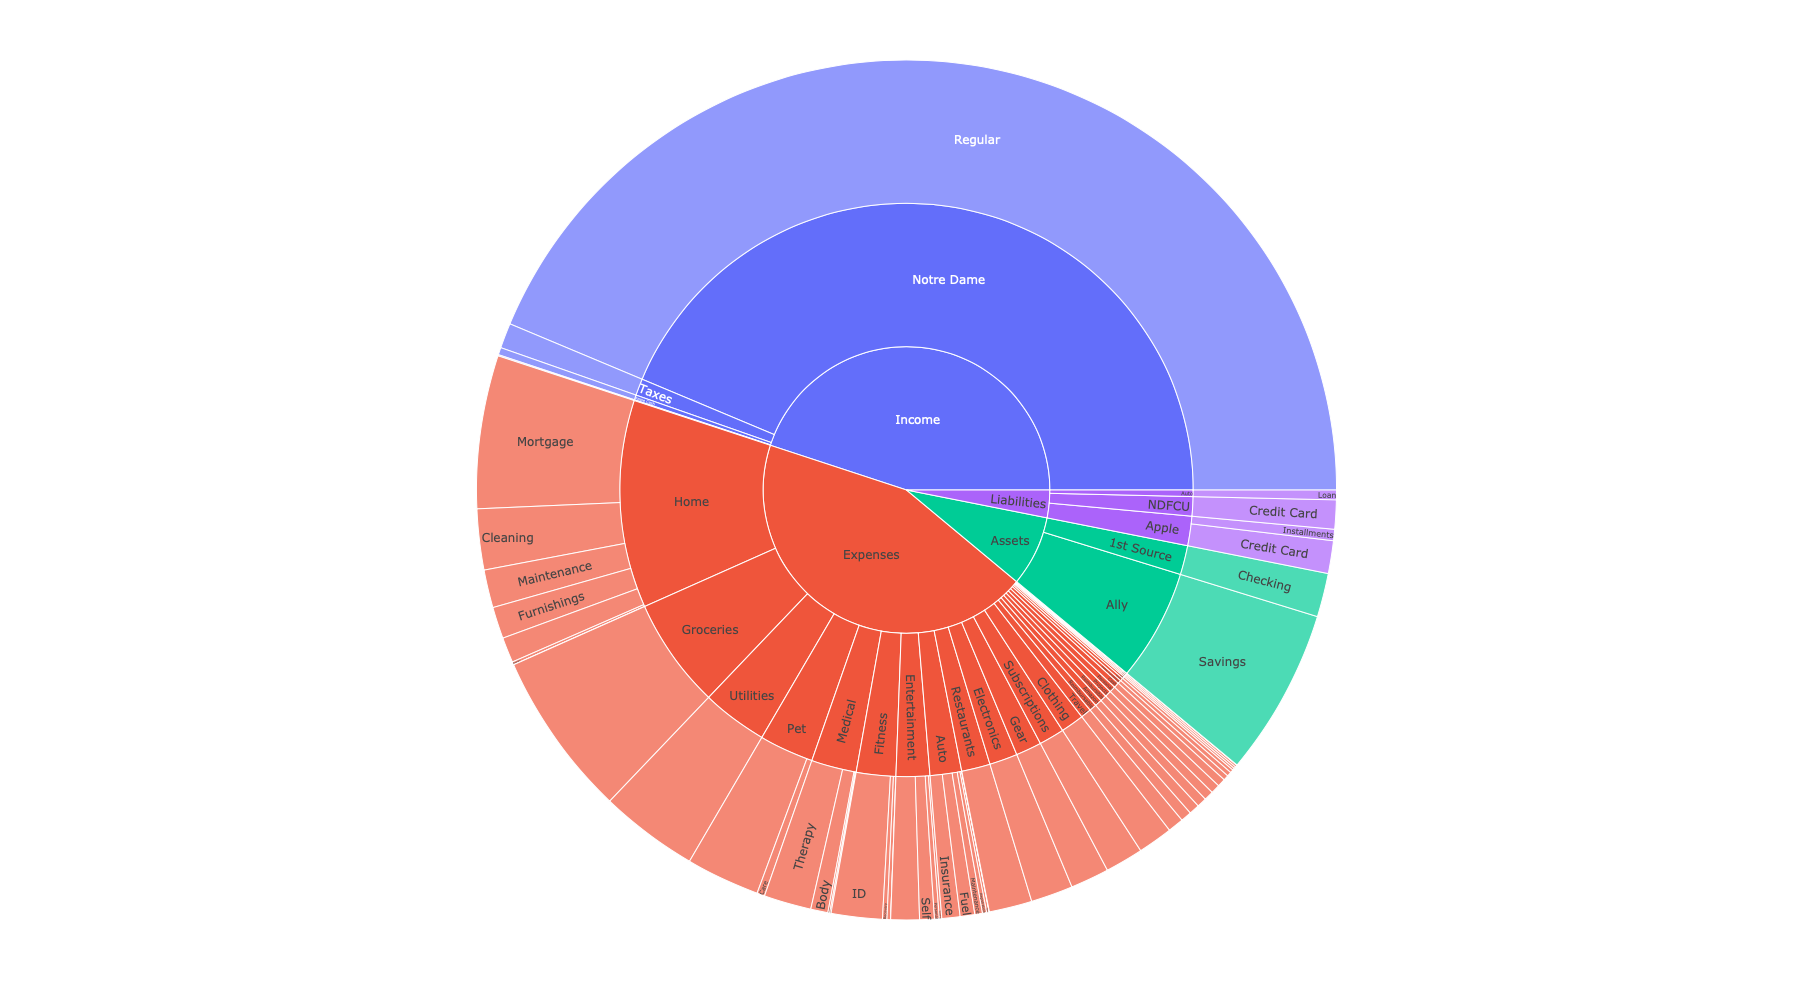

In [69]:
df = cb
df = pd.DataFrame({"Type": cb.index.get_level_values("Type"),
                   "Account": cb.index.get_level_values("Account"),
                   "Subaccount": cb.index.get_level_values("Subaccount"),
                  "Ending Balance": cb["Ending Balance"].apply(np.abs)})
df = df.loc[df["Type"] != "Transfer"]
#df = df.loc[
sbfig = px.sunburst(df, path=["Type", "Account", "Subaccount"], values="Ending Balance")
sbfig.update_layout(height=1000)


In [14]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])

In [15]:
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))
flow_df

Amount
From                          To                                     
Assets:1st Source:Checking    Expenses:Auto:Insurance         2042.05
                              Expenses:Auto:Registration       260.35
                              Expenses:Cash                   1313.25
                              Expenses:Fitness:Equipment       100.00
                              Expenses:Fitness:ID             4725.00
...                                                               ...
Liabilities:NDFCU:Credit Card Transfer                         141.81
Transfer                      Assets:1st Source:Checking      9981.50
                              Assets:Ally:Savings             1200.00
                              Liabilities:Apple:Credit Card  48843.47
                              Liabilities:NDFCU:Credit Card  54210.82

[101 rows x 1 columns]

In [18]:
accts = list(accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )


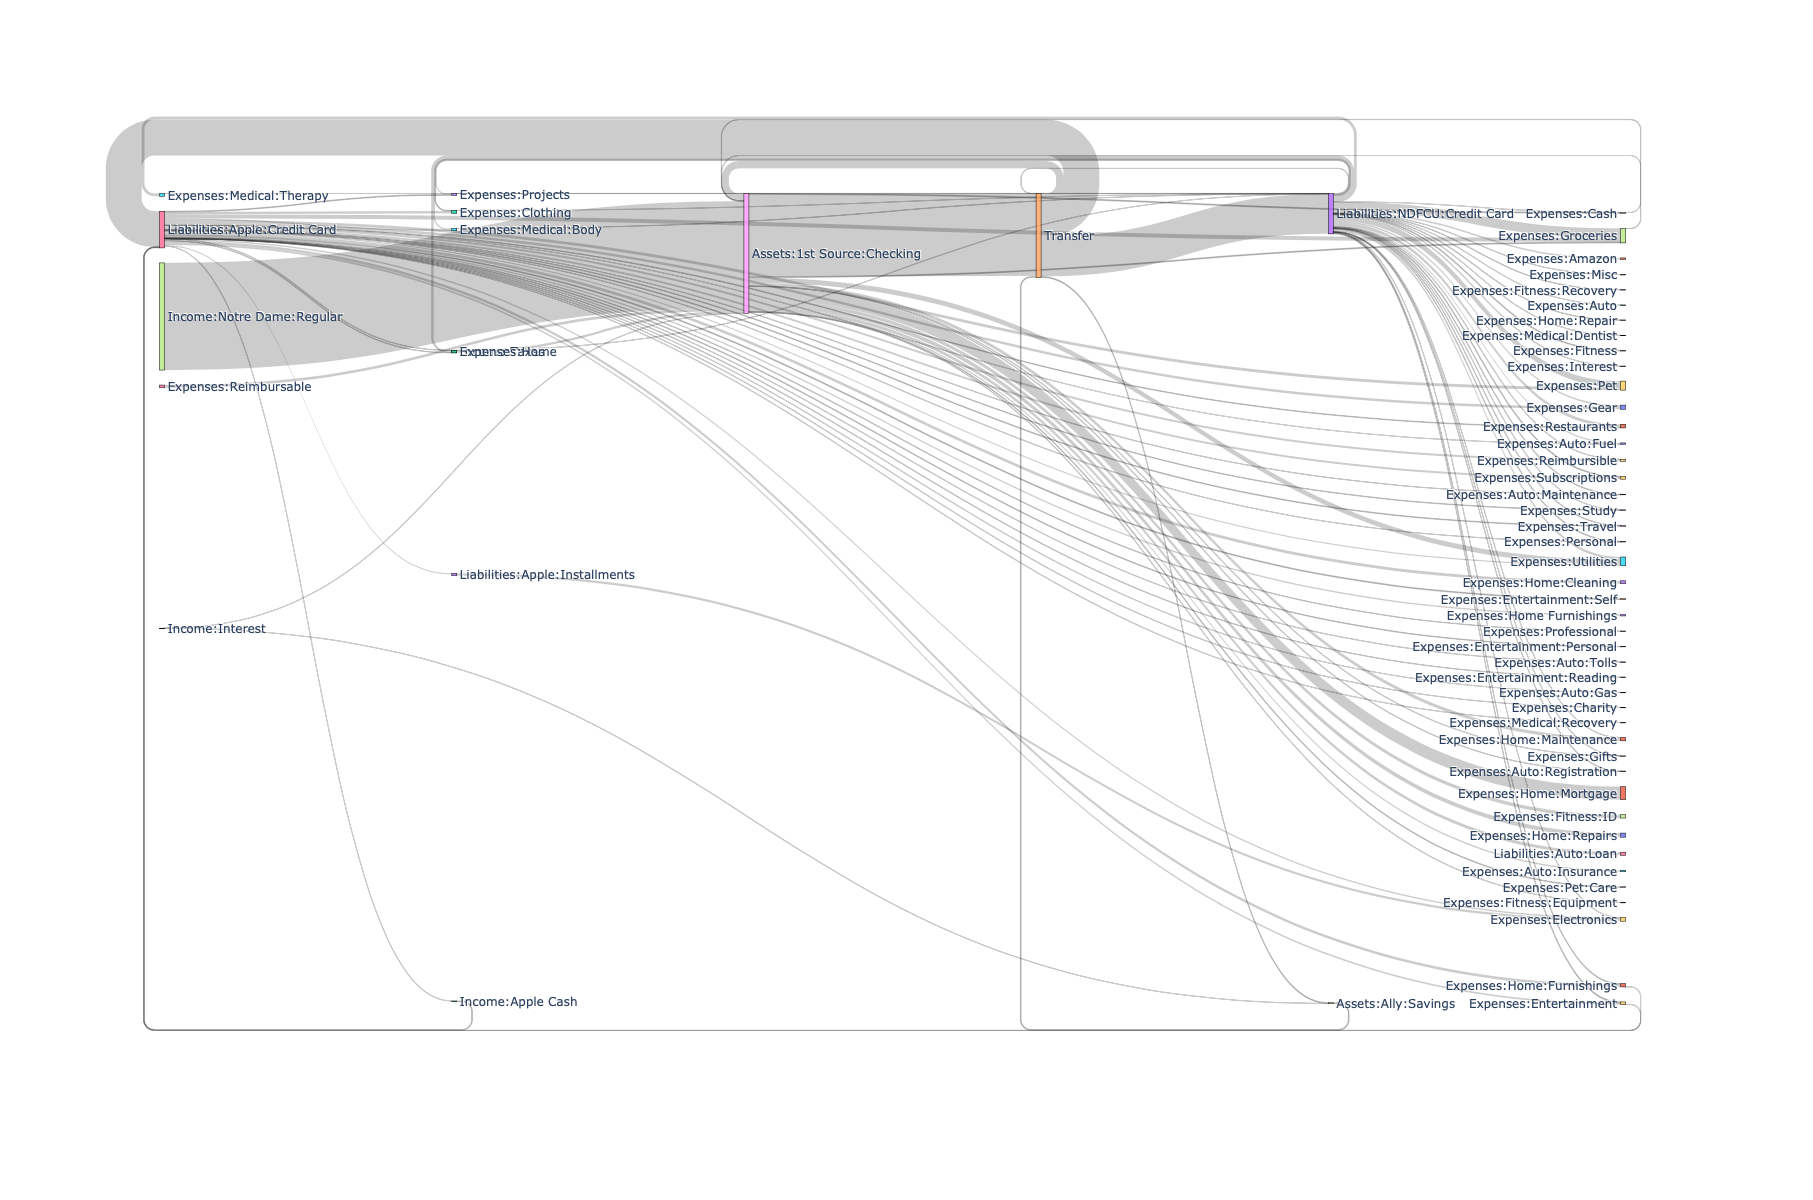

In [19]:
f.update_layout(height=1200)
f.show()

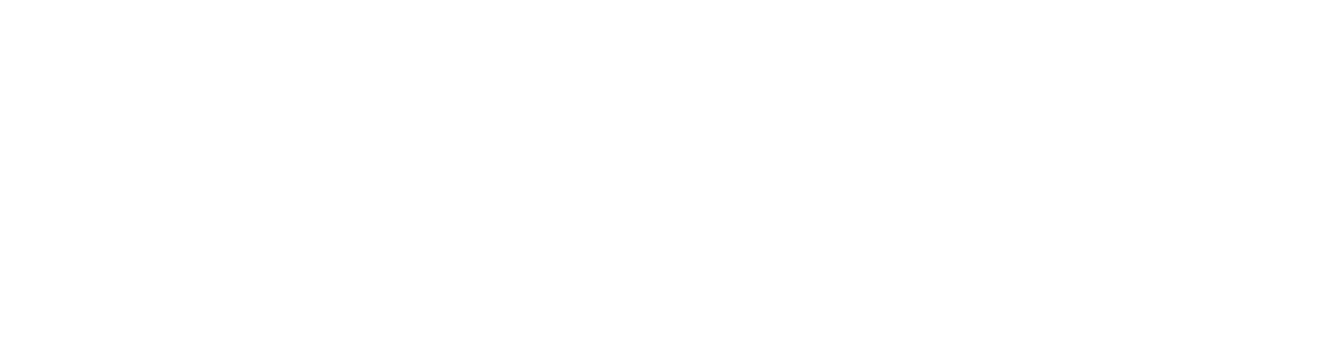

In [22]:
acct_bals.index
labels = []
parents = []
values = []
seen = []
ids = []
for tpl in acct_bals.index:
    ids.append(":".join(tpl))
    if tpl[2] != '':
        labels.append(tpl[2])
        parents.append(tpl[1])
        values.append(acct_bals["Ending Balance"].loc[tpl])
    elif tpl[1] != '':
        labels.append(tpl[1])
        parents.append(tpl[0])
        values.append(acct_bals["Ending Balance"].loc[tpl[0:-1]].sum())
    else:
        labels.append(tpl[0])
        parents.append("")
        values.append(acct_bals["Ending Balance"].loc[tpl[0]].sum())

fig = px.sunburst(names=labels, parents=parents, ids=ids)
fig.show()

In [19]:
fig.data

(Sunburst({
     'ids': [Assets::, Assets:1st Source:, Assets:1st Source:Checking,
             Assets:Ally:, Assets:Ally:Savings, Expenses::, Expenses:Amazon:,
             Expenses:Amazon:, Expenses:Auto:, Expenses:Auto:, Expenses:Auto:Fuel,
             Expenses:Auto:Gas, Expenses:Auto:Insurance, Expenses:Auto:Maintenance,
             Expenses:Auto:Registration, Expenses:Auto:Tolls, Expenses:Cash:,
             Expenses:Cash:, Expenses:Charity:, Expenses:Charity:,
             Expenses:Clothing:, Expenses:Clothing:, Expenses:Electronics:,
             Expenses:Electronics:, Expenses:Entertainment:,
             Expenses:Entertainment:, Expenses:Entertainment:Personal,
             Expenses:Entertainment:Reading, Expenses:Entertainment:Self,
             Expenses:Fitness:, Expenses:Fitness:, Expenses:Fitness:Equipment,
             Expenses:Fitness:ID, Expenses:Fitness:Recovery, Expenses:Gear:,
             Expenses:Gear:, Expenses:Gifts:, Expenses:Gifts:, Expenses:Groceries:,
     

In [82]:
med = pd.concat([cutoff_ledgers[l] for l in cutoff_ledgers if l.startswith("Expenses:Medical")]).sort_values("Date")